In [ ]:
# Importaciones básicas para operaciones matemáticas y manejo del sistema
import os  # Para interactuar con el sistema operativo (manejo de archivos/directorios)
import numpy as np  # Biblioteca fundamental para cálculos numéricos con arrays

# Importaciones para visualización de datos
import matplotlib.pyplot as plt  # Biblioteca para creación de gráficos y visualizaciones
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Para matriz de confusión

# Importaciones para procesamiento de imágenes
from PIL import Image  # Biblioteca para manipulación de imágenes
import cv2  # OpenCV para procesamiento de imágenes avanzado
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Generador de datos aumentados
from tensorflow.keras.utils import load_img, img_to_array  # Herramientas para carga de imágenes

# Importaciones principales de TensorFlow/Keras
import tensorflow as tf  # Framework principal para deep learning
from tensorflow import keras  # API de alto nivel para TensorFlow
from tensorflow.keras import layers  # Capas para construir modelos

# Importaciones específicas para arquitectura de modelos
from tensorflow.keras.models import Sequential, Model  # Modelos secuenciales y funcionales
from tensorflow.keras.layers import (Dense, Flatten, Dropout, BatchNormalization,
                                    Conv2D, MaxPooling2D)  # Tipos de capas para redes neuronales

# Importaciones para transfer learning y modelos pre-entrenados
from tensorflow.keras.applications import MobileNetV2  # Modelo pre-entrenado para clasificación de imágenes

# Importaciones para optimización y entrenamiento
from tensorflow.keras.optimizers import Adam  # Optimizador popular
from tensorflow.keras.callbacks import EarlyStopping  # Para detener entrenamiento temprano si no mejora

# Utilidades para manejo de datos
from sklearn.model_selection import train_test_split  # Para dividir datos en train/test/validation

In [ ]:
# Montar Google Drive (si es necesario)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images_from_folder(folder, target_size=(64, 64)):
  # Inicialización de listas para almacenar datos
    images = []  # Lista para almacenar arrays de imágenes
    labels = []  # Lista para almacenar etiquetas correspondientes

    # Configuración para clasificación binaria (Paso 1 vs No Paso 1)
    subfolders = sorted(os.listdir(folder))  # Obtiene y ordena subcarpetas

    # Mapeo de etiquetas:
    # - Asigna 0 si el nombre de la subcarpeta contiene 'Step1'
    # - Asigna 1 para cualquier otro caso (clasificación binaria)
    label_mapping = {subfolder: 0 if 'Step1' in subfolder else 1 for subfolder in subfolders}

    # Procesamiento de cada subcarpeta
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)  # Ruta completa a subcarpeta

        # Verifica que sea un directorio (protección contra archivos)
        if os.path.isdir(subfolder_path):
            # Procesamiento de cada imagen en la subcarpeta
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)  # Ruta completa a imagen

                try:
                    # Carga y preprocesamiento de la imagen:
                    img = Image.open(img_path).convert('RGB')  # Abre y convierte a RGB (3 canales)
                    img = img.resize(target_size)  # Redimensiona al tamaño objetivo

                    # Almacena la imagen y su etiqueta correspondiente
                    images.append(np.array(img))  # Convierte imagen a array numpy
                    labels.append(label_mapping[subfolder])  # Añade etiqueta según mapeo

                except Exception as e:
                    # Manejo de errores para imágenes corruptas o problemas de carga
                    print(f"Error loading image {img_path}: {e}")

    # Configuración final para clasificación binaria
    num_classes = 2  # Siempre será 2 por la naturaleza binaria del problema

    # Conversión a arrays numpy y retorno
    return np.array(images), np.array(labels), num_classes

In [ ]:
# Cargar los datos
data_folder = "/content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames"
X, y, num_classes = load_images_from_folder(data_folder)
X = X / 255.0  # Normalización
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Error loading image /content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step204: [Errno 21] Is a directory: '/content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step204'
Error loading image /content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step205: [Errno 21] Is a directory: '/content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step205'
Error loading image /content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step206: [Errno 21] Is a directory: '/content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step206'
Error loading image /content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step207: [Errno 21] Is a directory: '/content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step207'
Error loading image /content/drive/MyDrive/PRACTICAS LAVADO DE MANOS/Frames 2/Frames/Step2/step216: [Errno 21] Is a directory: '/content/drive/MyDrive/PRACTICAS LAVADO 

Características clave del modelo:
1. Arquitectura profunda con 3 bloques convolucionales + 2 bloques densos
2. Múltiples técnicas contra overfitting:
    - Dropout progresivo (20% -> 30%)
    - Regularización L2 en capas densas
    - BatchNormalization en casi todas las capas
3. Progresión natural en complejidad:
    - Filtros: 32 -> 64 -> 128
    - Neuronas densas: 256 -> 128 -> 1
 4. Diseñado específicamente para imágenes de 64x64x3

 Notas de diseño:
 - Padding 'same' mantiene dimensiones espaciales en capas convolucionales
 - MaxPooling solo aparece después del tercer bloque convolucional
 - La separación explícita de BatchNorm y Activación mejora el control
 - La regularización L2 (λ=0.001) ayuda a prevenir sobreajuste

 Para compilar este modelo, se recomendaría:
 - Optimizador: Adam con learning rate ajustado
 - Función de pérdida: binary_crossentropy
 - Métrica: accuracy y/o AUC para problemas binarios

In [ ]:
# Definición de un modelo Sequential (flujo lineal de capas)
model = tf.keras.models.Sequential([
    # Capa de entrada - Define la forma de los datos de entrada (imágenes 64x64 con 3 canales RGB)
    tf.keras.layers.Input(shape=(64, 64, 3)),  # Formato (alto, ancho, canales)

    # --- Bloque Convolucional 1 ---
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # 32 filtros de 3x3
    # BatchNormalization: Normaliza las activaciones para acelerar el entrenamiento
    tf.keras.layers.BatchNormalization(),
    # Dropout: Apaga aleatoriamente el 20% de neuronas para prevenir overfitting
    tf.keras.layers.Dropout(0.2),

    # --- Bloque Convolucional 2 ---
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 filtros de 3x3
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  # Nuevamente 20% de dropout

    # --- Bloque Convolucional 3 ---
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # 128 filtros
    tf.keras.layers.Dropout(0.2),
    # MaxPooling: Reduce dimensionalidad conservando características importantes
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Reducción a la mitad (32x32)

    # --- Transición a capas densas ---
    # Flatten: "Aplana" los mapas de características a 1D para capas densas
    tf.keras.layers.Flatten(),

    # --- Bloque Denso 1 ---
    # Dense: Capa totalmente conectada con regularización L2 (penaliza pesos grandes)
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    # Separación explícita de activación para mayor claridad
    tf.keras.layers.Activation('relu'),
    # Mayor dropout en capas densas (30%)
    tf.keras.layers.Dropout(0.3),

    # --- Bloque Denso 2 ---
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    # --- Capa de Salida ---
    # Única neurona con activación sigmoide para clasificación binaria
    # (Output: probabilidad entre 0-1)
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid ideal para problemas binarios
])

In [ ]:
# Configuración del proceso de compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador Adam con tasa de aprendizaje de 0.001
              # Adam es generalmente una buena opción por defecto que combina
              # lo mejor de RMSprop y Momentum

    loss='binary_crossentropy',  # Función de pérdida para clasificación binaria
              # binary_crossentropy es la opción estándar para problemas con:
              # - Salida sigmoide (como en nuestra última capa)
              # - Etiquetas binarias (0 o 1)
              # Mide la divergencia entre predicciones y valores reales

    metrics=['accuracy']  # Métrica principal a monitorear
              # Accuracy (exactitud) muestra el porcentaje de clasificaciones correctas
              # Es intuitiva y fácil de interpretar
)

# Configuración de Early Stopping para prevenir sobreentrenamiento
early_stopping = EarlyStopping(
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
              # Permite 5 épocas de posible estancamiento antes de parar

    monitor='val_loss',  # Métrica a observar para decidir parada
              # Se usa val_loss (pérdida en validación) en lugar de training loss
              # porque es mejor indicador de generalización

    restore_best_weights=True,  # Restaura los pesos del modelo de la época con mejor val_loss
              # Esto asegura que no nos quedemos con pesos de épocas posteriores
              # que puedan haber empeorado el modelo

    verbose=1  # Nivel de verbosidad (1 muestra mensajes cuando se detiene)
)

In [ ]:
# Proceso de entrenamiento del modelo de red neuronal
history = model.fit(
    x=X_train,  # Datos de entrenamiento (features)
                # Deben coincidir con la forma de entrada del modelo (64x64x3 en este caso)

    y=y_train,  # Etiquetas de entrenamiento (target)
                # Para clasificación binaria: array 1D con valores 0 o 1

    validation_data=(X_test, y_test),  # Conjunto de validación/test
                # Datos independientes para evaluar generalización del modelo
                # Idealmente debería ser un conjunto de validación separado, no de test
                # (pero comúnmente se usa test cuando no hay validación separada)

    epochs=150  # Número máximo de iteraciones sobre todo el dataset
                # En la práctica, el early stopping podría terminar antes el entrenamiento
                # (aunque en este caso está comentado el callback correspondiente)

    #callbacks=[early_stopping]  # Actualmente desactivado
                # Si se descomenta, se usaría el early_stopping configurado previamente
                # que monitorearía val_loss y restauraría los mejores pesos
)

Epoch 1/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9671 - loss: 0.2461 - val_accuracy: 0.9677 - val_loss: 0.2398
Epoch 2/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9706 - loss: 0.2310 - val_accuracy: 0.9738 - val_loss: 0.1599
Epoch 3/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9680 - loss: 0.2048 - val_accuracy: 0.9740 - val_loss: 0.1773
Epoch 4/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9704 - loss: 0.1947 - val_accuracy: 0.9261 - val_loss: 0.3497
Epoch 5/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9673 - loss: 0.2337 - val_accuracy: 0.9644 - val_loss: 0.1611
Epoch 6/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9699 - loss: 0.1918 - val_accuracy: 0.9644 - val_loss: 0.2044
Epoch 7/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9706 - loss: 0.1851 - val_accuracy: 0.9723 - val_loss: 0.1989
Epoch 8/150
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9694 - loss: 0

In [ ]:
# Guardar el modelo entrenado
model.save("modelo_binario_paso1_vs_todos.h5")

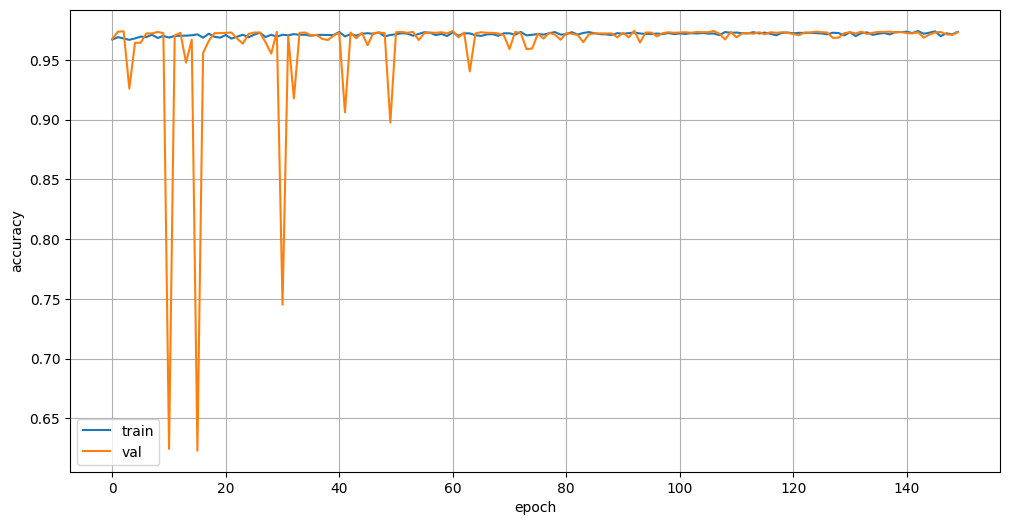

In [ ]:
# Plot validation and testing accuracy
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['accuracy']) # Se gráfica la exactitud del modelo a través de las épocas.
plt.plot(history.history['val_accuracy']) # Se gráfica la exactitud del modelo con los datos de validación del entrenamiento a través de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('accuracy') # El eje y corresponde a las exactitud.
plt.legend(['train', 'val']) # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

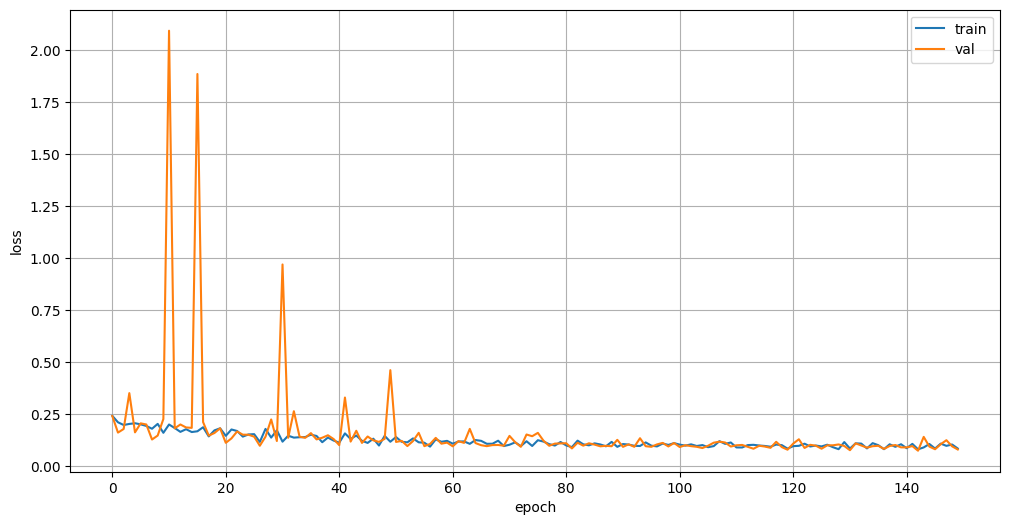

In [ ]:
# Plot validation and testing loss
plt.figure(figsize=(12,6)) # Se establece el tamaño de la gráfica.
plt.plot(history.history['loss']) # Se gráfica la pérdida del conjunto de entrenamiento a lo largo de las épocas.
plt.plot(history.history['val_loss']) # Se gráfica la pérdida con los datos de validación del entrenamiento a lo largo de las épocas.
plt.xlabel('epoch') # El eje x corresponde a las épocas.
plt.ylabel('loss') # El eje y corresponde a la pérdida.
plt.legend(['train', 'val'])  # Se añade una leyenda para distinguir entre entrenamiento y validación.
plt.grid(); # Se añade una cuadrícula a la gráfica para mejorar la legibilidad.

In [ ]:
model.summary() # Muestra un resumen del modelo.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,046,725 (385.46 MB)

 Trainable params: 33,681,921 (128.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 67,363,844 (256.97 MB)

In [ ]:
# Función para predecir y mostrar imágenes con sus etiquetas reales y predicciones
import random  # Para selección aleatoria de imágenes

def predict_and_display_images(model, images, labels=None, num_images=3):
    # Selección de imágenes:
    if images is None:
        # Si no se proporcionan imágenes, selecciona aleatoriamente del conjunto de test
        indices = random.sample(range(len(X_test)), num_images)  # Genera índices aleatorios
        sample_images = X_test[indices]  # Obtiene las imágenes correspondientes
        sample_labels = y_test[indices] if labels is not None else None  # Etiquetas si existen
    else:
        # Usa las primeras N imágenes del conjunto proporcionado
        sample_images = images[:num_images]
        sample_labels = labels[:num_images] if labels is not None else None

    # Predicción con el modelo:
    predictions = model.predict(sample_images)  # Obtiene probabilidades [0-1]
    # Convierte probabilidades a clases binarias (umbral 0.5)
    predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]

    # Visualización:
    plt.figure(figsize=(10, 5))  # Crea figura con tamaño personalizado

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)  # Crea subplots en una fila

        # Muestra la imagen (asume formato correcto para imshow)
        plt.imshow(sample_images[i])

        # Construye texto para la etiqueta real (si está disponible)
        true_label = ""
        if sample_labels is not None:
            # Asigna texto descriptivo según la clase (0->'Paso 1', 1->'No Paso 1')
            true_label = f"Real: {'Paso 1' if sample_labels[i] == 0 else 'No Paso 1'}"

        # Construye texto para la predicción:
        # - Muestra clase predicha (con mismo formato que etiqueta real)
        # - Muestra confianza (probabilidad) con 3 decimales
        pred_text = f"Pred: {'Paso 1' if predicted_classes[i] == 0 else 'No Paso 1'}\nConf: {predictions[i][0]:.3f}"

        # Combina ambos textos en el título
        plt.title(f"{true_label}\n{pred_text}")
        plt.axis('off')  # Oculta ejes para mejor visualización

    plt.tight_layout()  # Ajusta espaciado entre subplots
    plt.show()  # Muestra la figura completa

Prueba de sistema de predicción

Predicciones en imágenes de prueba:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


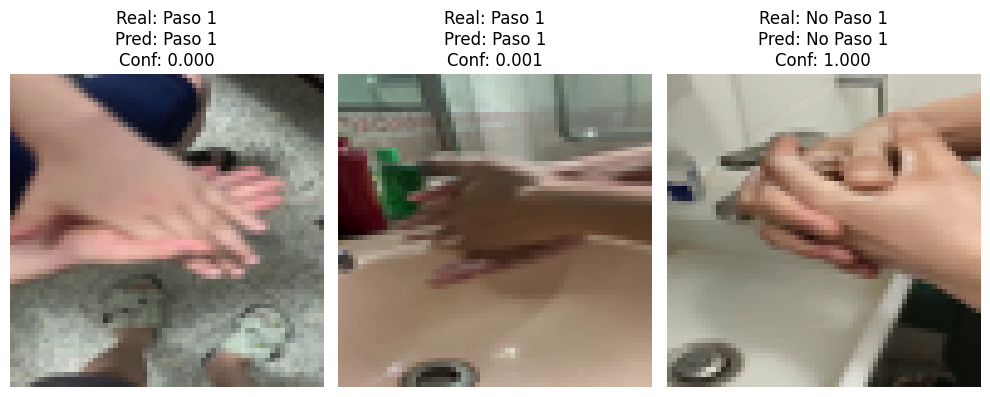

In [ ]:
#Predecir con imágenes del conjunto de prueba
print("Predicciones en imágenes de prueba:")
predict_and_display_images(model, None, y_test)
